# Demo of RE derivative based pattern matching

In this notebook, we first present many examples of parsing a given regular expression (RE) and building a parse tree. This parsing is done using the standard Lex and Yacc mechanisms and has nothing to do with RE derivatives. The reason we need to parse an RE is of course to build an abstract syntax tree for it so that further processing wrt this RE is facilitated. The functions defined are:
* re2ast - parse an ER and render it as an AST, and also return a list of nodes (nl) and edges (el)
* drawPT - which takes the nl and el and draws the parse tree for RE so that you can visually confirm the AST built for it

We then ask the primary question that this notebook aspires to demonstrate -- whether a given string _matches the given RE_. This pattern match itself is computed using RE derivatives. The workhorse routines that accomplish this task are
* nullable : given an RE, determine whether it is nullable (includes $\varepsilon$ in its language)
* dv : given a character c and an RE, it determines the derivative RE of the given RE w.r.t. c
* matches : given a word w and an RE, it determines whether w is matched by the RE (w is in the language
  of the RE).

In [1]:
import sys
sys.path[0:0] = ['../..','../../3rdparty'] # Put these at the head of the search path
from jove.Def_rederiv import *

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)

You may use any of these help commands:
help(re2ast)
help(drawPT)



In [2]:
(ast, nl, el) = re2ast("''*")
drawPT(nl, el)
ast

Generating LALR tables


('*', ('@', '@'))

Generating LALR tables


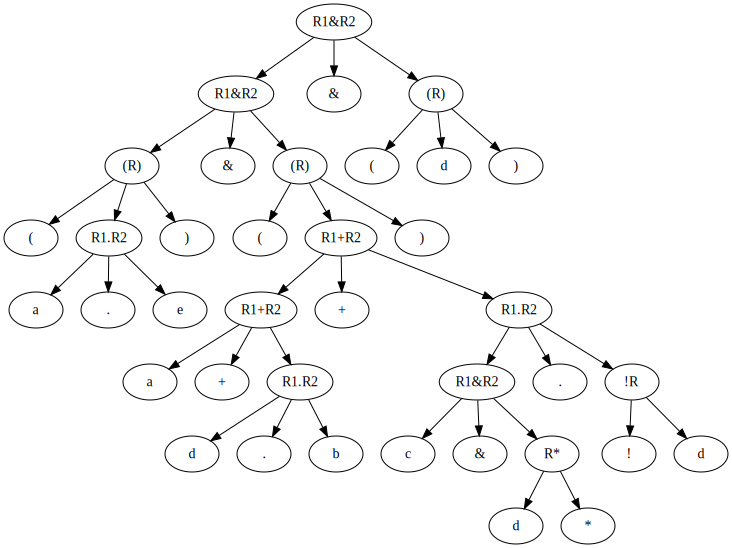

In [3]:
ResetStNum()
(ast, nl, el) = re2ast("(ae)&(a+db+c&d*!d)&(d)")
drawPT(nl, el)

Generating LALR tables


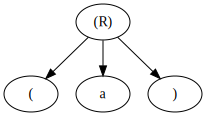

In [4]:
ResetStNum()
(ast, nl, el) = re2ast("(a)")
drawPT(nl, el)

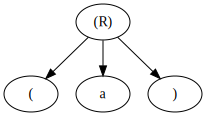

In [5]:
drawPT(nl, el)

In [6]:
(ast, nl, el) = re2ast("ab+cd''")

Generating LALR tables


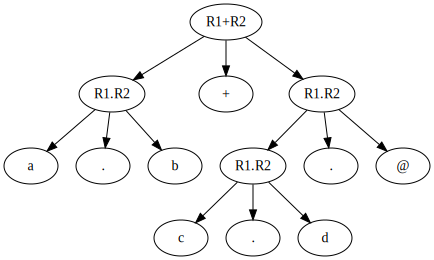

In [7]:
drawPT(nl, el) 

In [8]:
ast

('+',
 (('.', (('str', 'a'), ('str', 'b'))),
  ('.', (('.', (('str', 'c'), ('str', 'd'))), ('@', '@')))))

Generating LALR tables


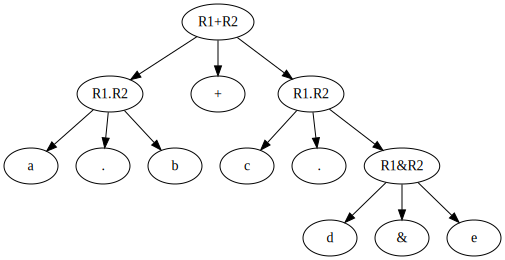

In [9]:
ResetStNum()
(ast, nl, el) = re2ast("ab+cd&e")
drawPT(nl, el)

In [10]:
#=== Now comes derivMatch as illustration of RE Derivative scanning

# These four functions are simple extractors of the operator and arguments

def opr(E):
    """Given an RE E represented as an AST with a root node of some arity,
       this function returns the root node (or the operator).
       For instance, given r1+r2, it will return r1.
    """
    return E[0]

def arg1(E):
    """Given an RE E represented as an AST with a root node of arity 2, 
       this function returns the first argument. 
       For instance, given r1+r2, it returns + and given r*, it returns *.
    """
    return E[1][0]

def arg2(E):
    """Given an RE E represented as an AST with a root node of arity 2, 
       this function returns the second argument. 
       For instance, given r1+r2, it will return r2.
    """
    return E[1][1]

def arg(E):
    """Given an RE E represented as an AST with a root node of arity 1, 
       this function returns the argument. For instance, given a*, it will return a.
    """
    return E[1]

def nullable(E):
    """Given an RE E represented as an AST, this function determines whether E is nullable.
    """
    if (opr(E) == "str") :
        return False
    elif (opr(E) == '@') :
        return True
    elif (opr(E) == "mty") :
        return False
    elif (opr(E) == "*"):
        return True
    elif (opr(E) == "!"):
        return not nullable(arg(E))
    elif (opr(E) == '+') :
        return nullable(arg1(E)) or nullable(arg2(E))
    elif (opr(E) == '.') :
        return nullable(arg1(E)) and nullable(arg2(E))
    elif (opr(E) == '&') :
        return nullable(arg1(E)) and nullable(arg2(E))
    else:
        return "???"    

def dv(c, E):
    """Given a character c and an RE E represented as an AST, this function 
       computes the Brzozowski derivative of E with respect to c, returning a new RE.
    """
    if (opr(E) == "str") :
        if (arg(E) == c):
            return ('@', '@')
        else:
            return ("mty", "mty")
    elif (opr(E) == '@') :
        return ("mty", "mty")
    elif (opr(E) == "mty") :
        return ("mty", "mty")
    elif (opr(E) == "*"):
        return (".", (dv(c, arg(E)), E))
    elif (opr(E) == "!"):
        return ("!", dv(c, arg(E)))
    elif (opr(E) == '+') :
        return ("+", (dv(c, arg1(E)), dv(c, arg2(E))))
    elif (opr(E) == '&') :
        return ("&", (dv(c, arg1(E)), dv(c, arg2(E))))
    elif (opr(E) == '.') :
        if nullable(arg1(E)):
            return ("+", ( ('.', (dv(c,arg1(E)), arg2(E))), dv(c, arg2(E)) ))
        else:
            return ('.', (dv(c,arg1(E)), arg2(E)))
    else:
        return "???"        

def matches(w, E):
    """Given a word w and an RE E represented as an AST, this function, 
       determines whether w is included in the language of E (or in other words, RE E 
       pattern-matches word w).
    """
    if w=="":
        return nullable(E)
    else:
        return matches(w[1:], dv(w[0], E))

Generating LALR tables


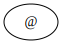

In [11]:
(ast,nl,el)  = re2ast("''")
drawPT(nl, el)

In [12]:
ast

('@', '@')

In [13]:
opr(ast)

'@'

In [14]:
nullable(ast)

True

In [15]:
ast

('@', '@')

In [16]:
dv('a', ast)

('mty', 'mty')

In [17]:
(pt, nl, el) = re2ast("!((aaa)*)")

print(' matches("aa", pt) = ', matches("aa", re2ast("!((aaa)*)")[0]))
re4 = '(a+b)*b(a+b)(a+b)(a+b)'
nre4 = '!((a+b)*b(a+b)(a+b)(a+b))'

(pt4, nl4, el4) = re2ast(re4)

print(' matches("aabaa", pt4) = ', matches("aabaa", pt4))

(npt4, nnl4, nel4) = re2ast(nre4)

print(' matches("aabaa", re2ast(nre4)) = ', matches("aabaa", npt4))


matches("ab", re2ast("!b")[0])


 matches("aa", pt) =  True
 matches("aabaa", pt4) =  False
 matches("aabaa", re2ast(nre4)) =  True


Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables


True

Generating LALR tables


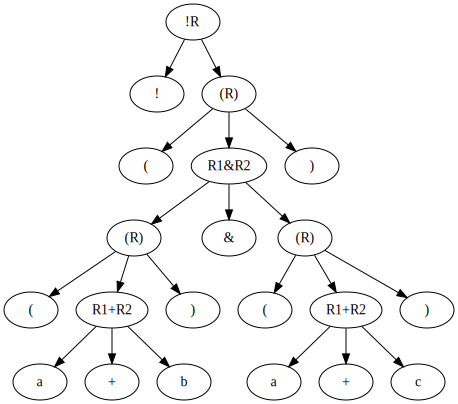

In [18]:
reand = '!((a+b)&(a+c))'
(pt, nl, el) = re2ast(reand)
drawPT(nl, el)

In [19]:
matches("b", pt)

True

Generating LALR tables


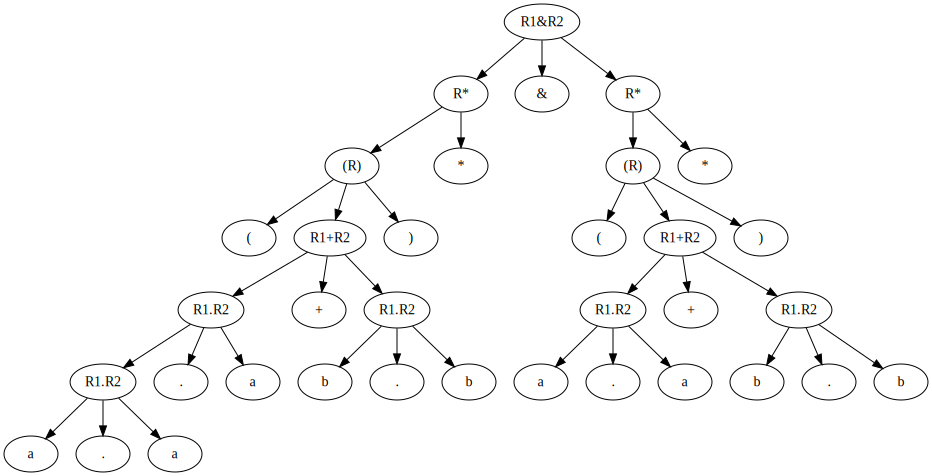

In [20]:
reand = '(aaa+bb)*&(aa+bb)*'
(pt, nl, el) = re2ast(reand)
drawPT(nl, el)

In [21]:
matches("bbb", pt)

False

# End of demonstration of RE derivative based parsing